# WEEK4 simple Recurrent neural network RNN

In [8]:
import pandas as pd
import numpy as np
#data = pd.read_csv('twitter_with_label.csv')
data = pd.read_csv('cleaned_with_label.csv', encoding='ISO-8859-1')
data=data[['text','rating']]
data.head()

,text,rating
0,hey yum sangria snorkel sound amaz glad fun,4
1,enjoy sunday dinner,4
2,show awesom vega u make last night tour memor,4
3,damon welcom twitter nation,4
4,amp think find mine leav guy thought well,0


<Axes: xlabel='rating', ylabel='count'>

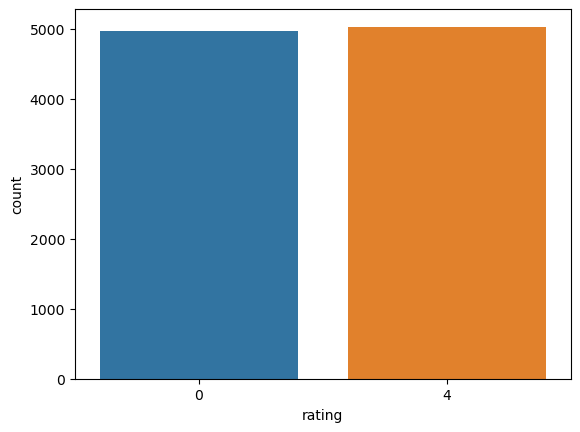

In [9]:
import seaborn as sns
sns.countplot(x='rating', data=data)

In [10]:
# import necessary libraries
import tensorflow.keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Transforming Data for NN

In [12]:
data = data.dropna()

# convert to numpy array 
text_ = data.text.to_numpy()

rating_ = data.rating.to_numpy()
rating = data.rating.replace(4,1)
rating_ = pd.get_dummies(rating_).to_numpy()



# Convert any numeric values in the list to strings
text_ = [str(x) for x in text_ if not isinstance(x, (int, float))]

#tokenizer = Tokenizer(num_words=nb_words) # eg. max vocab 20000
tokenizer = Tokenizer(num_words=20000,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

tokenizer.fit_on_texts(text_)


# length of sequence 
max_len = 35

# calcultaete number of words
#  in order to limit the size of the vocabulary to prevent overfitting and improve model performance.
nb_words = len(tokenizer.word_index) + 1

#to convert a list of texts into sequences of integers
sequences = tokenizer.texts_to_sequences(text_)

# calculate the total tokens
word_index = tokenizer.word_index
print(' %s unique tokens found.' % len(word_index))

# fixed length of vector to feed Neural Network
data_seq = pad_sequences(sequences, maxlen=max_len, padding="post")

 7940 unique tokens found.


In [13]:
print(data_seq.shape)
print(rating_.shape)

(9936, 35)
(9936, 2)


In [14]:
# train and test split
train_X, test_X, train_y, test_y = train_test_split(data_seq, rating_, 
                                                    test_size = 0.25, random_state=41, shuffle=True)


### Define and Combine the model

In [15]:
# adopted from https://github.com/haochen23/nlp-rnn-lstm-sentiment/blob/master/senti_tran_eval.py
# author : Dr. Hao Chen, Ph. D in Mechatronics Engineering.
def build_model(nb_words, rnn_model="SimpleRNN", embedding_matrix=None):

    model = Sequential()
    # add an embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(nb_words, 
                        500, 
                        weights=[embedding_matrix], 
                        input_length= max_len,
                        trainable = False))
    else:
        model.add(Embedding(nb_words, 
                        500, 
                        input_length= max_len,
                        trainable = False))
        
    # add an RNN layer according to rnn_model
    if rnn_model == "SimpleRNN":
        model.add(SimpleRNN(200))
    elif rnn_model == "LSTM":
        model.add(LSTM(200))
    else:
        model.add(GRU(200))
        
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    #model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', #'categorical_crossentropy'
                optimizer='adam',
                metrics=['accuracy'])
    return model


In [16]:
# calcultaete number of words
nb_words = len(tokenizer.word_index) + 1

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words,500)) #200

#for word, i in word_index.items():
#    embedding_vector = glove_model.get(word)
#    if embedding_vector is not None:
#        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 7941


In [17]:
# building the model
rnn = build_model(nb_words, "SimpleRNN", embedding_matrix)
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 500)           3970500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 200)               140200    
                                                                 
 dense (Dense)               (None, 32)                6432      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,117,198
Trainable params: 146,698
Non-trainable params: 3,970,500
_________________________________________________________________


In [18]:
history = rnn.fit(train_X, train_y, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
187/187 [==============================] - 8s 31ms/step - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6930 - val_accuracy: 0.5111
Epoch 2/10
187/187 [==============================] - 4s 21ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6930 - val_accuracy: 0.5111
Epoch 3/10
187/187 [==============================] - 6s 33ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6930 - val_accuracy: 0.5111
Epoch 4/10
187/187 [==============================] - 5s 28ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 5/10
187/187 [==============================] - 6s 30ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 6/10
187/187 [==============================] - 5s 29ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 7/10
187/187 [==============================] - 6s 30ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6930 - val_accuracy: 0.5111

### build and predict

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

rnn_history =rnn.fit(train_X, train_y, epochs=10, batch_size=100,
        validation_data=(test_X, test_y), 
        callbacks=EarlyStopping(monitor='val_accuracy', 
                                mode='min',
                                patience=3))

rnn_pred = rnn.predict(test_X)
rnn_pred = rnn_pred.argmax(axis=1)
# generate the report
print(classification_report(test_y.argmax(axis=1), rnn_pred))

Epoch 1/10
75/75 [==============================] - 3s 42ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6933 - val_accuracy: 0.4968
Epoch 2/10
75/75 [==============================] - 2s 33ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6932 - val_accuracy: 0.4968
Epoch 3/10
75/75 [==============================] - 3s 36ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6933 - val_accuracy: 0.4968
Epoch 4/10
78/78 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1250
           1       0.50      1.00      0.66      1234

    accuracy                           0.50      2484
   macro avg       0.25      0.50      0.33      2484
weighted avg       0.25      0.50      0.33      2484



C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
score = rnn.evaluate(test_X, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6932462453842163
Test accuracy: 0.4967793822288513


### plot the outcomes

In [21]:
import matplotlib.pyplot as plt
def plot_hist(history, title):
    """
    Vars:
    - history: A Keras History object representing the training history of a model.
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    
    ax1.plot(history.history['accuracy'], c= 'b')
    ax1.plot(history.history['val_accuracy'], c='r')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    ax2.plot(history.history['loss'], c='m')
    ax2.plot(history.history['val_loss'], c='c')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')
     # Add a title to the entire image
    fig.suptitle(title, fontsize=14)
    plt.show()

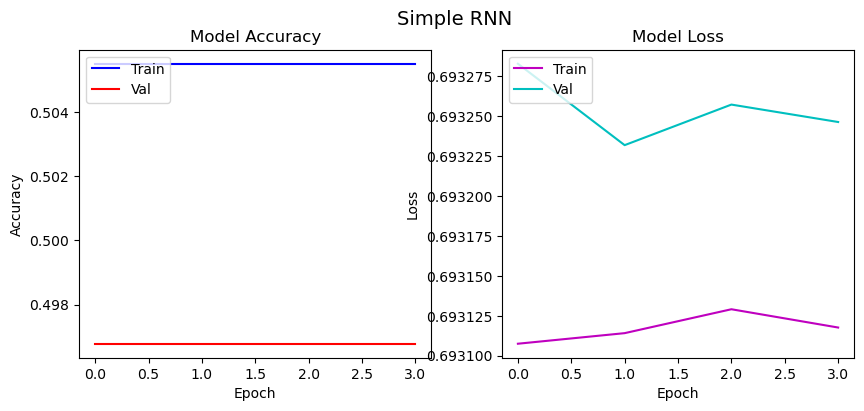

In [22]:
plot_hist(rnn_history,'Simple RNN')

In [65]:
rnn_pred
print(classification_report(test_y.argmax(axis=1), rnn_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1250
           1       0.50      1.00      0.66      1234

    accuracy                           0.50      2484
   macro avg       0.25      0.50      0.33      2484
weighted avg       0.25      0.50      0.33      2484



C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(test_y,axis=1), rnn_pred)*100))

Accuracy:	49.7%
